In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
sns.set(style='whitegrid')

In [106]:
import os
from os.path import join

# Introduction

## Aim

Compute the results of the analysis of the 0D model sensitivity analysis. In particular, implement the pipeline to extract sensitivity analysis data, save latex tables. 

## Prerequisites

* Run the script `script_sensitivity_analysis.py` for several values of epsilon
    * Run in folders with name format: `epsilon_<value>` (e.g. `epsilon_0.01`)
* For each generated subfolders in `epsilon_<value>/`, process with the script `test_dnnmodelevaluation.m` and copy the `table.csv`, `Xexact.csv` and `Xpredicted.csv` files
* Each `epsilon_<value>/` folder should contain the following (contents of `outputs/` directory is not shown): 

```
.
├── P0_Param_LeftVentricle_Emax0
│   ├── outputs
│   ├── parameters.txt
│   ├── table.csv
│   ├── Xexact.csv
│   └── Xpredicted.csv
├── P1_Param_LeftVentricle_EmaxRef0
│   ├── outputs
│   ├── parameters.txt
│   ├── table.csv
│   ├── Xexact.csv
│   └── Xpredicted.csv
├── P2_Param_LeftVentricle_AGain_Emax
│   ├── outputs
│   ├── parameters.txt
│   ├── table.csv
│   ├── Xexact.csv
│   └── Xpredicted.csv
└── P3_Param_LeftVentricle_kE
    ├── outputs
    ├── parameters.txt
    ├── table.csv
    ├── Xexact.csv
    └── Xpredicted.csv
```

## How to use

**For each value of $\mathbf\epsilon$, you should rerun the notebook and modify the `identifier` accordingly** (see the cell below).

## Setup



In [107]:
identifier = 'epsilon_0.2'
path = f'/media/maousi/Raw/sensitivity/{identifier}/'

# Check data

## Aim

Verify that simulations in each directory actually has a single varying parameter. Visualize parameters distribution.

In [108]:
# Data containing values of the parameter that varies in a given folder
param_data = {}

for folder in os.listdir(path):
    print(f'=== {folder}')
    file = join(path, folder, 'parameters.txt')
    # Check file contents (that indeed a single parameter varies)
    #!head -4 $file | tail -3
    
    param_name = folder[folder.find('_')+1:]
    df = pd.read_csv(file)
    print(df.head(4).values)
    param_data[param_name] = df[param_name].values

=== P0_Param_LeftVentricle_Emax0
[[0.         1.81843787 1.296      0.3375     0.0125    ]
 [1.         1.54919433 1.296      0.3375     0.0125    ]
 [2.         1.45712284 1.296      0.3375     0.0125    ]
 [3.         1.21077018 1.296      0.3375     0.0125    ]]
=== P1_Param_LeftVentricle_EmaxRef0
[[0.         1.575      1.66458096 0.3375     0.0125    ]
 [1.         1.575      1.19335567 0.3375     0.0125    ]
 [2.         1.575      1.29666344 0.3375     0.0125    ]
 [3.         1.575      1.43582703 0.3375     0.0125    ]]
=== P2_Param_LeftVentricle_AGain_Emax
[[0.         1.575      1.296      0.41734606 0.0125    ]
 [1.         1.575      1.296      0.28795952 0.0125    ]
 [2.         1.575      1.296      0.15963965 0.0125    ]
 [3.         1.575      1.296      0.3472621  0.0125    ]]
=== P3_Param_LeftVentricle_kE
[[0.         1.575      1.296      0.3375     0.01572441]
 [1.         1.575      1.296      0.3375     0.01075126]
 [2.         1.575      1.296      0.3375     0.

/home/maousi/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/maousi/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/maousi/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or

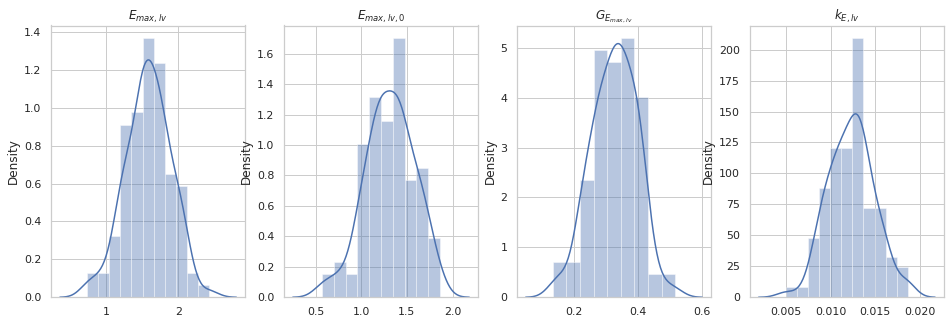

In [109]:
fig, axes = plt.subplots(1, len(param_data), figsize=(16,5))

paramslatex = dict(zip(param_data.keys(), ['$E_{max,lv}$', '$E_{max,lv,0}$', '$G_{E_{max,lv}}$', '$k_{E,lv}$']))
for p, ax in zip(param_data, axes):
    sns.distplot(param_data[p], ax=ax, norm_hist=True)
    ax.set_title(paramslatex[p])

# Extract values

In [110]:
# Define utility function to format results table
def format_table(table):
    table.index = [
        'Min exact', 'Max exact', 'Mean exact', 'SD exact', 'Min pred', 
        'Max pred', 'Mean pred', 'SD pred', 'Avg err mx', 
        'Avg rel err%', 'SD error', 'CI min', 'CI max',
    ]
    table.columns = [
        'HR','SAPM','SAPS','SAPD', 'PAPM','PAPS','PAPD','LVEF',
        'LVEDV', 'LVESV', 'CI', 'PCPW'
    ]
    table.CI = table.CI.apply(np.abs)
    cols = {'Min exact': 'Min', 'Max exact': 'Max', 'Mean exact': 'Mean', 'SD exact': 'SD'}
    table = table.loc[list(cols.keys()), :]
    table = table.rename(cols)
    #table.index = table.index.set_levels(['Emax0','EmaxRef0','GainEmax','kE'], level=0)
    #table.index = ['Emax0','EmaxRef0','GainEmax','kE']
    #table.index.rename({'Param_LeftVentricle_Emax0':'test'}, inplace=True, level=0)
    return table

In [111]:
raw = {}
for folder in os.listdir(path):
    file = join(path, folder, 'table.csv')
    print(file)
    df = pd.read_csv(file, header=None)
    df = format_table(df)
    param_name = folder[folder.find('_')+1:]
    raw[param_name] = df

/media/maousi/Raw/sensitivity/epsilon_0.2/P0_Param_LeftVentricle_Emax0/table.csv
/media/maousi/Raw/sensitivity/epsilon_0.2/P1_Param_LeftVentricle_EmaxRef0/table.csv
/media/maousi/Raw/sensitivity/epsilon_0.2/P2_Param_LeftVentricle_AGain_Emax/table.csv
/media/maousi/Raw/sensitivity/epsilon_0.2/P3_Param_LeftVentricle_kE/table.csv


In [112]:
df = pd.concat(raw)
df.index = df.index.set_levels(['$E_{max,lv}$', '$E_{max,lv,0}$', 
                                '$G_{E_{max,lv}}$', '$k_{E,lv}$'], level=0)
df

HR        SAPM        SAPS       SAPD  \
$E_{max,lv}$     Min   66.666667   95.115683  122.901039  80.990045   
                 Max   68.965517   96.394641  123.986622  82.715246   
                 Mean  67.786739   96.078863  123.546080  82.345254   
                 SD     0.332678    0.299549    0.287512   0.351824   
$E_{max,lv,0}$   Min   66.666667   87.117637  109.490187  75.931362   
                 Max   72.727273   98.016394  128.406033  83.168831   
                 Mean  68.146636   95.770422  123.166877  82.072194   
                 SD     1.268279    2.111939    3.624085   1.416506   
$G_{E_{max,lv}}$ Min   66.666667   93.705696  120.407178  80.354955   
                 Max   68.965517   97.033535  125.516646  82.917917   
                 Mean  67.966067   96.048388  123.280253  82.432456   
                 SD     0.548172    0.634629    1.108858   0.432024   
$k_{E,lv}$       Min   64.516129   86.306015  109.280402  74.818822   
                 Max   74.074074  105.824542  137.846418  89.813605   
                 Mean  68.338311   95.521072  123.618276  81.472470   
                 SD     1.985552    3.752666    5.778651   2.807912   

                            PAPM       PAPS       PAPD       LVEF       LVEDV  \
$E_{max,lv}$     Min   18.111691  28.242337  13.046369  48.627291  151.712976   
                 Max   18.491354  28.503628  13.485218  54.520531  157.219721   
                 Mean  18.271341  28.333080  13.240471  51.893716  153.852261   
                 SD     0.080611   0.039637   0.106012   2.013879    1.067551   
$E_{max,lv,0}$   Min   17.445970  28.045863  12.146024  39.757224  143.754424   
                 Max   19.974797  29.389756  15.267318  61.114419  175.461101   
                 Mean  18.286458  28.367607  13.245883  52.360834  154.141548   
                 SD     0.478604   0.233034   0.605647   4.245401    6.219161   
$G_{E_{max,lv}}$ Min   17.947796  28.190268  12.786780  48.312695  149.702124   
                 Max   18.654421  28.503540  13.729862  55.344673  159.817958   
                 Mean  18.302057  28.344497  13.280837  51.628748  154.147321   
                 SD     0.154350   0.068367   0.198475   2.390976    1.898708   
$k_{E,lv}$       Min   13.712874  25.228761   7.954931  48.304780  125.213399   
                 Max   21.810560  30.800892  17.315394  54.991034  188.263577   
                 Mean  18.108279  28.239970  13.042434  52.315186  154.667038   
                 SD     1.621251   1.115213   1.875299   1.668783   12.523554   

                            LVESV        CI       PCPW  
$E_{max,lv}$     Min    69.334827  1.890159   8.513152  
                 Max    79.344106  2.016415   9.193822  
                 Mean   74.028078  1.904332   8.818415  
                 SD      3.491002  0.015256   0.142497  
$E_{max,lv,0}$   Min    55.899743  1.554471   7.646687  
                 Max   105.702638  2.241786  11.521024  
                 Mean   73.671504  1.928685   8.872142  
                 SD      9.466391  0.141718   0.753139  
$G_{E_{max,lv}}$ Min    67.667683  1.808688   8.338586  
                 Max    80.386612  2.017097   9.543313  
                 Mean   74.598160  1.892602   8.870561  
                 SD      4.432869  0.041846   0.238898  
$k_{E,lv}$       Min    63.807937  1.435497   2.821334  
                 Max    89.599862  2.502421  13.663342  
                 Mean   73.705408  1.971717   8.647296  
                 SD      5.992688  0.229656   2.149175

In [113]:
df.to_latex(f'data/sensitivity_analysis_{identifier}.tex', float_format="%.4g", 
            multirow=True, escape=False, caption=identifier.replace('_', ' '))#, longtable=True)

# Plot parameter distribution



In [114]:
path = '/media/maousi/Data/tmp/sensitivity'
params = []
# For each value of epsilon
for folder in os.listdir(path):
    print(folder)
    # Extract epsilon value
    epsilon = folder.split('_')[-1]
    epsilon = float(epsilon)
    print(epsilon)
    # For each 0D model parameter
    dfepsilon = []
    for subfolder in os.listdir(join(path, folder)):
        print(subfolder)
        # Extract parameter name
        param = subfolder[3:]
        print(param)
        # Read parameters.txt file
        pathtmp = join(path, folder, subfolder)
        print(os.listdir(join(path, folder, subfolder)))
        dftmp = pd.read_csv(join(pathtmp, 'parameters.txt'))
        print(param in dftmp.columns)
        # Extract the column of the varying parameter
        dfepsilon.append(dftmp[param])
    
    # Merge the parameter values for a given epsilon
    dfepsilon = pd.DataFrame(dfepsilon).transpose()
    # Spefiy the value of epsilon
    dfepsilon['epsilon'] = epsilon
    params.append(dfepsilon)

# Merge everything
params = pd.concat(params, ignore_index=True)

epsilon_0.01
0.01
P0_Param_LeftVentricle_Emax0
Param_LeftVentricle_Emax0
['outputs', 'parameters.txt', 'table.csv', 'Xexact.csv', 'Xpredicted.csv']
True
P1_Param_LeftVentricle_EmaxRef0
Param_LeftVentricle_EmaxRef0
['outputs', 'parameters.txt', 'table.csv', 'Xexact.csv', 'Xpredicted.csv']
True
P2_Param_LeftVentricle_AGain_Emax
Param_LeftVentricle_AGain_Emax
['outputs', 'parameters.txt', 'table.csv', 'Xexact.csv', 'Xpredicted.csv']
True
P3_Param_LeftVentricle_kE
Param_LeftVentricle_kE
['outputs', 'parameters.txt', 'table.csv', 'Xexact.csv', 'Xpredicted.csv']
True
epsilon_0.05
0.05
P0_Param_LeftVentricle_Emax0
Param_LeftVentricle_Emax0
['outputs', 'parameters.txt', 'table.csv', 'Xexact.csv', 'Xpredicted.csv']
True
P1_Param_LeftVentricle_EmaxRef0
Param_LeftVentricle_EmaxRef0
['outputs', 'parameters.txt', 'table.csv', 'Xexact.csv', 'Xpredicted.csv']
True
P2_Param_LeftVentricle_AGain_Emax
Param_LeftVentricle_AGain_Emax
['outputs', 'parameters.txt', 'table.csv', 'Xexact.csv', 'Xpredicted.csv'

In [115]:
names = [p for p in params.columns if p != 'epsilon']
names = list(zip(names, ['$E_{max,lv}$', '$E_{max,lv,0}$', '$G_{E_{max,lv}}$', '$k_{E,lv}$']))
names

[('Param_LeftVentricle_Emax0', '$E_{max,lv}$'),
 ('Param_LeftVentricle_EmaxRef0', '$E_{max,lv,0}$'),
 ('Param_LeftVentricle_AGain_Emax', '$G_{E_{max,lv}}$'),
 ('Param_LeftVentricle_kE', '$k_{E,lv}$')]

In [116]:
epsilons = params.epsilon.unique()
epsilons

array([0.01, 0.05, 0.1 , 0.2 ])

/home/maousi/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/maousi/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/maousi/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

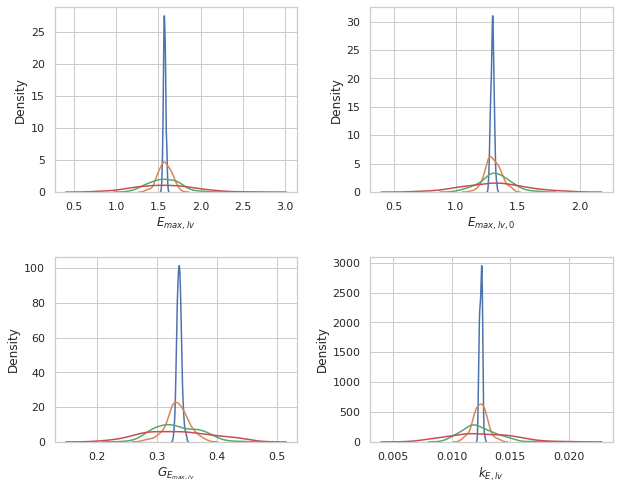

In [117]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for (p, platex), ax in zip(names, axes):
    for epsilon in epsilons:
        sns.distplot(params.loc[params.epsilon == epsilon, p], 
                     ax=ax, hist=False, 
                     label=r'$\epsilon = ' + str(epsilon) + '$')
    ax.set_xlabel(platex)
        
plt.subplots_adjust(hspace=.35, wspace=.3)